
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated


TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable

In [1]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

import pprint
from IPython.display import display as ipydisp    
import collections
import itertools
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.utils import wavg,get_wavg_by
from notebooks.aduriseti_shared.utils import *

NOW = datetime.datetime.now()
TODAY = NOW.date()
DAY = datetime.timedelta(days=1)

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

#     location_os = ["state", "dma", "operating_system"],
#     location_device=["state", "dma", "device", ],
#     location_os_device = ["state", "dma", "operating_system","device"],
)

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

start_date = TODAY - 90*DAY
eval_date = TODAY - 30*DAY
end_date = TODAY
traffic_source = GOOGLE
# traffic_source = TABOOLA

split2aggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(start_date,end_date,None,traffic_source=traffic_source,agg_columns=tuple(split_cols+["utc_dt"]))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2aggrps[split] = rps_df
    print(split,rps_df.shape)

Attempting to load environ from: `SM_ENV_BASE`
...Success!!


Matplotlib created a temporary config/cache directory at /home/runner/.config/matplotlib because the default path (/tmp/matplotlib-9f89erg5) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


browser ['browser']


INFO:root:query: SELECT browser,utc_dt, COUNT(session_id)                    ... executed in 36.97 seconds
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


session uniqueness assummption not satisfied
browser (99, 10)
operating_system ['operating_system']


INFO:root:query: SELECT operating_system,utc_dt, COUNT(session_id)           ... executed in 29.76 seconds


session uniqueness assummption not satisfied
operating_system (457, 10)
device ['device']


INFO:root:query: SELECT device,utc_dt, COUNT(session_id)                     ... executed in 29.37 seconds


session uniqueness assummption not satisfied
device (267, 10)
product ['product']


INFO:root:query: SELECT product,utc_dt, COUNT(session_id)                    ... executed in 29.34 seconds


session uniqueness assummption not satisfied
product (178, 10)
TOD ['dayofweek', 'hourofday']


INFO:root:query: SELECT dayofweek,hourofday,utc_dt, COUNT(session_id)        ... executed in 36.2 seconds


session uniqueness assummption not satisfied
TOD (10176, 10)
dma ['dma']


INFO:root:query: SELECT dma,utc_dt, COUNT(session_id)                        ... executed in 43.32 seconds


session uniqueness assummption not satisfied
dma (18033, 10)
state ['state']


INFO:root:query: SELECT state,utc_dt, COUNT(session_id)                      ... executed in 33.06 seconds


session uniqueness assummption not satisfied
state (4539, 10)
location ['state', 'dma']


INFO:root:query: SELECT state,dma,utc_dt, COUNT(session_id)                  ... executed in 29.75 seconds


session uniqueness assummption not satisfied
location (26063, 10)
dma_os ['dma', 'operating_system']


INFO:root:query: SELECT dma,operating_system,utc_dt, COUNT(session_id)       ... executed in 42.92 seconds


session uniqueness assummption not satisfied
dma_os (69820, 10)
dma_device ['dma', 'device']


INFO:root:query: SELECT dma,device,utc_dt, COUNT(session_id)                 ... executed in 48.8 seconds


session uniqueness assummption not satisfied
dma_device (44538, 10)
dma_os_device ['dma', 'operating_system', 'device']


INFO:root:query: SELECT dma,operating_system,device,utc_dt, COUNT(session_id)... executed in 31.8 seconds


session uniqueness assummption not satisfied
dma_os_device (83036, 10)
state_os ['state', 'operating_system']


INFO:root:query: SELECT state,operating_system,utc_dt, COUNT(session_id)     ... executed in 31.74 seconds


session uniqueness assummption not satisfied
state_os (21805, 10)
state_device ['state', 'device']


INFO:root:query: SELECT state,device,utc_dt, COUNT(session_id)               ... executed in 30.1 seconds


session uniqueness assummption not satisfied
state_device (13134, 10)
state_os_device ['state', 'operating_system', 'device']


INFO:root:query: SELECT state,operating_system,device,utc_dt, COUNT(session_i... executed in 32.27 seconds


session uniqueness assummption not satisfied
state_os_device (30402, 10)


In [208]:
NOW = datetime.datetime.now()
TODAY = NOW.date()
DAY = datetime.timedelta(days=1)
start_date = TODAY - 90*DAY
eval_date = TODAY - 30*DAY
end_date = TODAY

In [275]:
import sklearn.preprocessing
import sklearn.cluster
import sklearn.tree

CLUSTS = 64

from models.utils import wstd
def get_split_factor(rps_df):
    split_attr2unique_vals = {c: rps_df.index.unique(c) for c in rps_df.index.names[:-1]}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    return rps_df.reset_index()[[*new_index_order[:-1],"clust"]].drop_duplicates().__len__()

class AggRPSClust:
    def __init__(self,clusts=CLUSTS,kpis=["rps","score","lps","rpl"]):
        self.clusts = clusts
        self.kpis = kpis
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        aggX = X.groupby(X.index.names[:-1]) \
            [["sessions","revenue"]].sum()
        aggX[self.kpis] = X.groupby(X.index.names[:-1]) \
            .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
        if len(aggX) > self.clusts:
            aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(aggX[self.kpis],sample_weight=aggX["sessions"])
        else:
            aggX["clust"] = np.arange(len(aggX))
        self.aggX = aggX
        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)
        
class TreeRPSClust:
    def __init__(self,clusts=CLUSTS,cma=7,enc_min_cnt=100,plot=True):
        self.clusts=clusts
        self.cma=cma
        self.enc_min_cnt = enc_min_cnt
        self.plot = plot
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
            
        split_idx = X.index.names[:-1]

        def translate(df,td):
            tdf = df.copy().reset_index()
            tdf['utc_dt'] = tdf['utc_dt'] + td
            return tdf.set_index(df.index.names)
        X = pd.concat((translate(X[["sessions","revenue"]],n*DAY) / self.cma 
                   for n in range(self.cma))) \
            .sum(level=[X.index.names])
        X["rps"] = X["revenue"] / X["sessions"]

        Xdf = X .reset_index()
        ydf = X["rps"]
        wdf = X["sessions"]

        ipydisp(Xdf[split_idx].isna().sum())
        for c in split_idx:
            too_few_I = Xdf.groupby(c)["sessions"].transform(sum) < self.enc_min_cnt
            Xdf.loc[too_few_I,c] = np.NaN
        ipydisp(Xdf[split_idx].isna().sum())
        #         Xdf = Xdf.astype(str).fillna("")
        Xdf = Xdf[split_idx]

        self.enc_1hot = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore") .fit(Xdf)
        self.enc_features = [*self.enc_1hot.get_feature_names()]
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        y = ydf.fillna(0)
        w = wdf

        self.clf = sklearn.tree.DecisionTreeRegressor(
                            min_weight_fraction_leaf=0.5/self.clusts) \
                        .fit(X,y,sample_weight=wdf)
        print(sklearn.tree.export_text(self.clf,feature_names=self.enc_features))

        yhat = self.clf.predict(X)
        print("Tree RPS MAE:",(y - yhat).abs().mean())

        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        Xdf = X .reset_index()[X.index.names].iloc[:,:-1]
#         X = self.enc_1hot.transform(Xdf.astype(str).fillna(""))
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        return self.clf.apply(X)
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

COKPI = "COKPI"
COOR = "COOR"
MEAN = "MEAN"
STACK = "STACK"
class KpiSimClust:
    def __init__(self,clusts=CLUSTS,kpis=["rps","score","lps","rpl"],sim=COKPI,mtd=MEAN,plot=True):
        self.clusts = clusts
        self.kpis = kpis
        self.plot = plot
        self.sim = sim
        self.mtd = mtd
        
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        
        aggX = X.groupby(X.index.names[:-1]) \
            [["sessions","revenue"]].sum()
        aggX[self.kpis] = X.groupby(X.index.names[:-1]) \
            .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
        buckets = aggX.index.values

        min_date = X.index.unique("utc_dt").min()
        max_date = X.index.unique("utc_dt").max()
        date_range = pd.date_range(min_date,max_date)
        kpi_tensor = np.stack(X.loc[bucket,self.kpis] \
                                  .reindex(date_range).fillna(0) \
                                  .rolling(7).mean().fillna(0)
                              for bucket in buckets)
        kpi_tensor = kpi_tensor.transpose(2,0,1)
        D, H, W = kpi_tensor.shape
        kpi_tensor.shape

        if self.plot:
            # i = (kpi_tensor > 0).sum(axis=1)[:,0].argmax()
            # i = kpi_tensor.sum(axis=2)[0,:].argmax()
            i = (kpi_tensor > 1e-3).sum(axis=2)[0].argmax()
            plt.plot(kpi_tensor[0,i,:])
            plt.show()
      
        if self.sim == COOR:
            mu = kpi_tensor.mean(axis=2).reshape(D, H, 1)
            std = kpi_tensor.std(axis=2).reshape(D, H, 1)
            kpi_tensor_norm = (kpi_tensor - mu) / std
            kpi_tensor_norm[np.isnan(kpi_tensor_norm)] = 0
            kpi_corr = (kpi_tensor_norm @ kpi_tensor_norm.transpose(0, 2, 1)) / W
#             assert np.abs(np.diag(loc_corr_df) - 1).max() < 1e-10
            assert (np.einsum('dii->di', kpi_corr) - 1).abs().max() < 1e-10
            kpi_sim = kpi_corr
        elif self.sim == COKPI:
            kpi_sqrt_tensor = kpi_tensor ** 0.5
            cokpi = (kpi_sqrt_tensor @ kpi_sqrt_tensor.transpose(0, 2, 1))
#             cokpi = np.nan_to_num(np.log(cokpi))
            ma = cokpi.max(axis=2).max(axis=1).reshape(D,1,1)
#             cokpi = cokpi / (ma + 1e-10)
            cokpi = cokpi / ma
            kpi_sim = cokpi
        else:
            raise
        
        if self.mtd == MEAN:
            kpi_sim = kpi_sim.mean(axis=0)
        elif self.mtd == STACK:
            kpi_sim = T.transpose(1,0,2).reshape(H,D*W)
        else:
            raise
        
        kpi_sim_df = pd.DataFrame(kpi_sim,index=buckets)

        if len(aggX) > self.clusts:
            aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(kpi_sim_df.values,sample_weight=aggX["sessions"])
        else:
            aggX["clust"] = np.arange(len(aggX))
        self.aggX = aggX
        
#         if plot:
#             for ci in range(CLUSTS):
#                 clust_kpi_df = pd.concat(kpi_df.loc[tuple(uval)] for uval in col_uvals[clust==ci]) \
#                     .reset_index()
#                 print(ci,"rps:",wavg(clust_kpi_df["rps"],clust_kpi_df["sessions"]))
#                 ipydisp(clust_kpi_df[["sessions",'revenue']].sum())
#                 clust_kpi_df \
#                     .groupby("utc_dt")["rps"] \
#                     .agg(get_wavg_by(clust_kpi_df,"sessions")) \
#                     .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
#                     .fillna(0).rolling(7).mean() \
#                     .plot(label=ci,figsize=(15,5))
#             plt.legend()
#             plt.show()
        
        return self
        
    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class HybridCorrTreeClust:
    def __init__(
            self,
            clusts=CLUSTS,enc_min_cnt=100,
            kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.enc_min_cnt = enc_min_cnt
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        self.splitcol2clusterer = {}
        for c in split_idx:
            aggX = X.groupby([c,"utc_dt"]) [["sessions","revenue"]].sum()
            aggX[self.kpis] = X.groupby([c,"utc_dt"]) \
                .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
            clusterer = KpiSimClust(
                                clusts=self.clusts,
                                kpis=self.kpis,
                                plot=False) \
                            .fit(aggX,None)
            clust = clusterer \
                .transform(X.reset_index().set_index([c,"utc_dt"]))
            self.splitcol2clusterer[c] = clusterer
            X[f"{c}_clust"] = clust.values
        
        clust_idx = [f"{c}_clust" for c in split_idx]
#         Xclust = X.groupby([*clust_idx,"utc_dt"]) \
#             [["sessions","revenue"]].sum()
#         Xclust[kpis] = X.groupby([*clust_idx,"utc_dt"]) \
#             .apply(lambda df: wavg(df[kpis],df["sessions"]))

        self.tree_clusterer = TreeRPSClust(
                clusts=self.clusts,
                enc_min_cnt=self.enc_min_cnt,
                plot=False) \
            .fit(X.reset_index().set_index([*clust_idx,"utc_dt"]),None)
        # clusterer = TreeRPSClust() \
        #     .fit(Xclust,None)

        return self
    
    def transform(self,X):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        clust_idx = [f"{c}_clust" for c in split_idx]
        for c,d in zip(split_idx,clust_idx):
            X[d] = self.splitcol2clusterer[c] \
                .transform(X.reset_index().set_index([c,"utc_dt"])) \
                .values
        return self.tree_clusterer \
            .transform(X.reset_index().set_index([*clust_idx,"utc_dt"]))
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,2,0.000000
1.0,303965,2.655689


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.008342991854717765,
 'clustered_split_factor': 6,
 'clusterer': <__main__.AggRPSClust object at 0x7f55b327ceb0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'browser',
 'split_variance': 0.008342991854717765}


browser    0
dtype: int64

browser    51
dtype: int64

|X| (118, 2)
|--- value: [2.38]

Tree RPS MAE: 2.064023340712302
|X| (69, 2)
|X| (30, 2)


,sessions,rps
clust,,
0,303968,2.655663


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55858def40>,
 'fit_shape': (3, 2),
 'rps_mae': 0.00012000129296743967,
 'split': 'browser',
 'split_variance': 0.008342991854717765}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


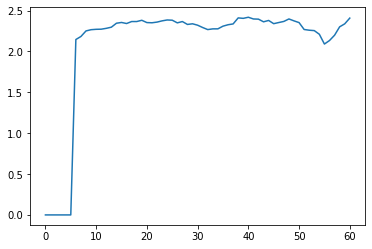

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,2,0.000000
1.0,303965,2.655689


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.008342991854717765,
 'clustered_split_factor': 6,
 'clusterer': <__main__.KpiSimClust object at 0x7f55858de370>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'browser',
 'split_variance': 0.008342991854717765}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


browser_clust    0
dtype: int64

browser_clust    51
dtype: int64

|X| (118, 2)
|--- value: [2.38]

Tree RPS MAE: 2.064023340712302
|X| (69, 2)
|X| (30, 2)


<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,303968,2.655663


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b361dbe0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.00012000129296743967,
 'split': 'browser',
 'split_variance': 0.008342991854717765}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,74468,2.527727
1.0,29605,2.998571
2.0,8,0.000000
3.0,65721,3.248475
4.0,126516,2.338114
5.0,7638,2.739888


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.36579503193929663,
 'clustered_split_factor': 10,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a43568e0>,
 'fit_shape': (7, 2),
 'rps_mae': 0.0,
 'split': 'operating_system',
 'split_variance': 0.36579503193929663}


operating_system    0
dtype: int64

operating_system    42
dtype: int64

|X| (377, 6)
|--- x0_Windows <= 0.50
|   |--- x0_Mac OS X <= 0.50
|   |   |--- x0_iOS <= 0.50
|   |   |   |--- x0_iPadOS <= 0.50
|   |   |   |   |--- value: [2.21]
|   |   |   |--- x0_iPadOS >  0.50
|   |   |   |   |--- value: [2.37]
|   |   |--- x0_iOS >  0.50
|   |   |   |--- value: [2.00]
|   |--- x0_Mac OS X >  0.50
|   |   |--- value: [2.71]
|--- x0_Windows >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 0.3788829068282571
|X| (311, 6)
|X| (146, 6)


,sessions,rps
clust,,
4,74477,2.527422
5,7638,2.739888
6,126516,2.338114
7,29605,2.998571
8,65721,3.248475


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.365536374991953,
 'clustered_split_factor': 5,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a53e63a0>,
 'fit_shape': (7, 2),
 'rps_mae': 9.088245950098846e-05,
 'split': 'operating_system',
 'split_variance': 0.36579503193929663}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


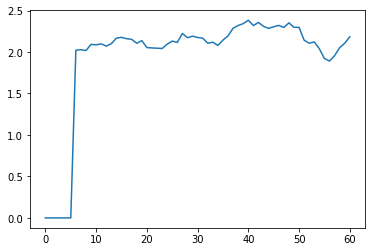

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,74468,2.527727
1.0,29605,2.998571
2.0,8,0.000000
3.0,65721,3.248475
4.0,126516,2.338114
5.0,7638,2.739888


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (7, 2),
 'cluster_variance': 0.36579503193929663,
 'clustered_split_factor': 10,
 'clusterer': <__main__.KpiSimClust object at 0x7f55e7d2efd0>,
 'fit_shape': (7, 2),
 'rps_mae': 0.0,
 'split': 'operating_system',
 'split_variance': 0.36579503193929663}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


operating_system_clust    0
dtype: int64

operating_system_clust    42
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (377, 6)
|--- x0_3.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |--- value: [2.21]
|   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |--- value: [2.37]
|   |   |--- x0_4.0 >  0.50
|   |   |   |--- value: [2.00]
|   |--- x0_1.0 >  0.50
|   |   |--- value: [2.71]
|--- x0_3.0 >  0.50
|   |--- value: [3.00]

Tree RPS MAE: 0.3788829068282584
|X| (311, 6)
|X| (146, 6)


,sessions,rps
clust,,
4,74477,2.527422
5,7638,2.739888
6,126516,2.338114
7,29605,2.998571
8,65721,3.248475


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.365536374991953,
 'clustered_split_factor': 5,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b361d880>,
 'fit_shape': (7, 2),
 'rps_mae': 9.088245950098846e-05,
 'split': 'operating_system',
 'split_variance': 0.36579503193929663}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,99082,3.207318
1,193818,2.367220
2,11068,2.768281


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.3907809281692665,
 'clustered_split_factor': 3,
 'clusterer': <__main__.AggRPSClust object at 0x7f5585e257c0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.3907809281692665}


device    0
dtype: int64

device    0
dtype: int64

|X| (201, 3)
|--- x0_DESK <= 0.50
|   |--- x0_PHON <= 0.50
|   |   |--- value: [2.47]
|   |--- x0_PHON >  0.50
|   |   |--- value: [2.04]
|--- x0_DESK >  0.50
|   |--- value: [2.93]

Tree RPS MAE: 0.14126837554371585
|X| (183, 3)
|X| (84, 3)


,sessions,rps
clust,,
2,11068,2.768281
3,193818,2.367220
4,99082,3.207318


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.39078092816926646,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a558f6a0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.3907809281692665}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


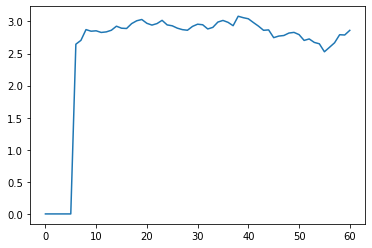

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,99082,3.207318
1,193818,2.367220
2,11068,2.768281


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.3907809281692665,
 'clustered_split_factor': 3,
 'clusterer': <__main__.KpiSimClust object at 0x7f55b3259b50>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.3907809281692665}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


device_clust    0
dtype: int64

device_clust    0
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (201, 3)
|--- x0_0.0 <= 0.50
|   |--- x0_2.0 <= 0.50
|   |   |--- value: [2.04]
|   |--- x0_2.0 >  0.50
|   |   |--- value: [2.47]
|--- x0_0.0 >  0.50
|   |--- value: [2.93]

Tree RPS MAE: 0.1412683755437158
|X| (183, 3)
|X| (84, 3)


,sessions,rps
clust,,
2,193818,2.367220
3,11068,2.768281
4,99082,3.207318


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.39078092816926646,
 'clustered_split_factor': 3,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f5585e0caf0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.3907809281692665}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,226289,2.592542
1,77679,2.839542


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10773369587686706,
 'clustered_split_factor': 2,
 'clusterer': <__main__.AggRPSClust object at 0x7f5585fa0520>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10773369587686706}


product    0
dtype: int64

product    0
dtype: int64

|X| (134, 2)
|--- x0_MEDICARE <= 0.50
|   |--- value: [2.26]
|--- x0_MEDICARE >  0.50
|   |--- value: [2.54]

Tree RPS MAE: 0.1273098181110558
|X| (122, 2)
|X| (56, 2)


,sessions,rps
clust,,
1,226289,2.592542
2,77679,2.839542


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10773369587686706,
 'clustered_split_factor': 2,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55b3255be0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10773369587686706}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


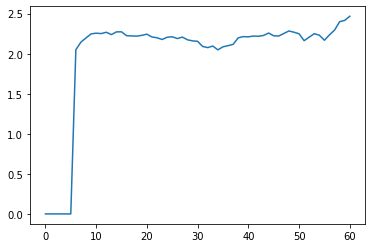

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,226289,2.592542
1,77679,2.839542


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10773369587686706,
 'clustered_split_factor': 2,
 'clusterer': <__main__.KpiSimClust object at 0x7f55b32758e0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10773369587686706}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


product_clust    0
dtype: int64

product_clust    0
dtype: int64

|X| (134, 2)
|--- x0_0.0 <= 0.50
|   |--- value: [2.54]
|--- x0_0.0 >  0.50
|   |--- value: [2.26]

Tree RPS MAE: 0.12730981811105596
|X| (122, 2)
|X| (56, 2)


<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
1,77679,2.839542
2,226289,2.592542


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10773369587686706,
 'clustered_split_factor': 2,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55a53b7ca0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10773369587686706}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,3127,2.287144
1,1844,1.664375
2,15173,3.010937
3,8544,1.889132
4,10646,3.297531
...,...,...
59,3111,2.109581
60,370,2.689564
61,3194,2.625035


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5091651214518104,
 'clustered_split_factor': 296,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a5643880>,
 'fit_shape': (672, 2),
 'rps_mae': 0.5016559645055587,
 'split': 'TOD',
 'split_variance': 0.7313062285324539}


dayofweek    0
hourofday    0
dtype: int64

dayofweek    0
hourofday    0
dtype: int64

|X| (41109, 103)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_21.75 <= 0.50
|   |   |   |--- x1_21.25 <= 0.50
|   |   |   |   |--- x1_21.0 <= 0.50
|   |   |   |   |   |--- x1_21.5 <= 0.50
|   |   |   |   |   |   |--- x1_20.75 <= 0.50
|   |   |   |   |   |   |   |--- x1_20.5 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_11.5 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_11.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 42
|   |   |   |   |   |   |   |   |   |   |--- x1_11.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.96]
|   |   |   |   |   |   |   |   |   |--- x1_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.98]
|   |   |   |   |   |   |   |   |--- x1_11.5 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.98]
|   |   |   |   |   |   |   |--- x1_20.5 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.85]
|   |

,sessions,rps
clust,,
52,13224,2.293959
53,14205,2.575842
54,16067,2.322499
55,12541,2.062133
56,2322,2.655486
57,2403,2.556381
58,2461,2.402067
59,19048,2.484301
60,4326,2.563101


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (53, 2),
 'cluster_variance': 0.5128302603857465,
 'clustered_split_factor': 234,
 'clusterer': <__main__.TreeRPSClust object at 0x7f5585f93400>,
 'fit_shape': (672, 2),
 'rps_mae': 0.33227206598918974,
 'split': 'TOD',
 'split_variance': 0.7313062285324539}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


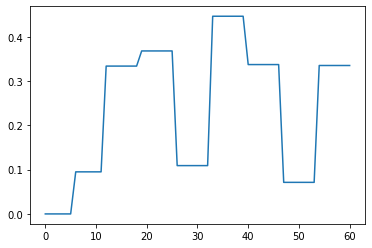

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,945,2.297318
1,11225,3.289965
2,2985,2.097282
3,305,2.756028
4,6081,2.988325
...,...,...
59,201,3.281539
60,1741,2.070889
61,3877,1.870275


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4964529434704208,
 'clustered_split_factor': 265,
 'clusterer': <__main__.KpiSimClust object at 0x7f5585f93430>,
 'fit_shape': (672, 2),
 'rps_mae': 0.5354524278300434,
 'split': 'TOD',
 'split_variance': 0.7313062285324539}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust

dayofweek_clust    0
hourofday_clust    0
dtype: int64

dayofweek_clust    0
hourofday_clust    0
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (27456, 71)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_13.0 <= 0.50
|   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |--- x1_27.0 <= 0.50
|   |   |   |   |   |--- x1_31.0 <= 0.50
|   |   |   |   |   |   |--- x1_10.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_43.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_41.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_51.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_20.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 21
|   |   |   |   |   |   |   |   |   |   |--- x1_20.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.69]
|   |   |   |   |   |   |   |   |   |--- x1_51.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.77]
|   |   |   |   |

,sessions,rps
clust,,
31,11383,2.330650
32,12608,2.245881
33,9758,2.027865
34,3453,1.819299
35,11864,2.121982
36,2455,2.897179
37,3755,2.396603
38,3368,2.449841
39,2980,1.583103


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (53, 2),
 'cluster_variance': 0.4866633348585123,
 'clustered_split_factor': 124,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55a55b8eb0>,
 'fit_shape': (672, 2),
 'rps_mae': 0.5761926052611513,
 'split': 'TOD',
 'split_variance': 0.7313062285324539}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,5535,2.547100
1,1412,1.310824
2,36581,1.929001
3,11618,2.800269
4,76,1.985789
...,...,...
59,384,3.556677
60,246,3.557683
61,68,0.830588


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.49239293460475425,
 'clustered_split_factor': 64,
 'clusterer': <__main__.AggRPSClust object at 0x7f55b3269dc0>,
 'fit_shape': (210, 2),
 'rps_mae': 0.6995783544033598,
 'split': 'dma',
 'split_variance': 0.5676514719746782}


dma    0
dtype: int64

dma    577
dtype: int64

|X| (14029, 202)
|--- x0_501 <= 0.50
|   |--- x0_803 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_807 <= 0.50
|   |   |   |   |--- x0_613 <= 0.50
|   |   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |   |--- x0_528 <= 0.50
|   |   |   |   |   |   |   |--- x0_534 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_862 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_512 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_539 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 23
|   |   |   |   |   |   |   |   |   |   |--- x0_539 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.09]
|   |   |   |   |   |   |   |   |   |--- x0_512 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.32]
|   |   |   |   |   |   |   |   |--- x0_862 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.61]
|   |   |   |   |   |   |   |--- x0_534 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.95]
|   |   |   |   |   |

,sessions,rps
clust,,
33,105589,2.742549
34,3201,3.225622
35,4790,2.654746
36,3340,2.822488
37,3281,3.175631
38,11351,2.636382
39,4987,2.619906
40,2798,2.700882
41,3567,2.920306


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (34, 2),
 'cluster_variance': 0.4096828181945531,
 'clustered_split_factor': 34,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55e7ceb310>,
 'fit_shape': (210, 2),
 'rps_mae': 0.547056670725598,
 'split': 'dma',
 'split_variance': 0.5676514719746782}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


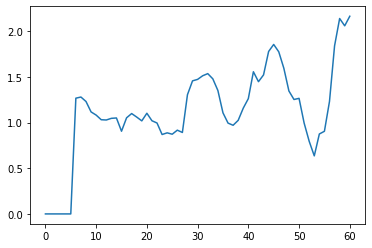

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,149,1.270023
1,10644,3.004900
2,28872,1.925803
3,25,1.285887
4,497,2.493224
...,...,...
59,47,1.345106
60,4509,2.835816
61,1803,1.686113


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4733165485784035,
 'clustered_split_factor': 64,
 'clusterer': <__main__.KpiSimClust object at 0x7f55a55b8040>,
 'fit_shape': (210, 2),
 'rps_mae': 0.7402331150226475,
 'split': 'dma',
 'split_variance': 0.5676514719746782}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


dma_clust    0
dtype: int64

dma_clust    383
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (4259, 59)
|--- x0_63.0 <= 0.50
|   |--- x0_39.0 <= 0.50
|   |   |--- x0_54.0 <= 0.50
|   |   |   |--- x0_46.0 <= 0.50
|   |   |   |   |--- x0_12.0 <= 0.50
|   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |--- x0_14.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_36.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_56.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_21.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_53.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_53.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.15]
|   |   |   |   |   |   |   |   |   |--- x0_21.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.32]
|   |   |   |   |   |   |   |   |--- x0_56.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.80]
|   |   |   |   |   |   |   |--- x0_36.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.95]
|   |   |

,sessions,rps
clust,,
21,18152,2.538801
22,5900,3.097865
23,7128,2.414735
24,2731,2.822555
25,15465,2.709030
26,10644,3.004900
27,40427,2.741318
28,10064,2.962753
29,4749,2.924980


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (22, 2),
 'cluster_variance': 0.43042785402180644,
 'clustered_split_factor': 22,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b361d640>,
 'fit_shape': (210, 2),
 'rps_mae': 0.7855398682293019,
 'split': 'dma',
 'split_variance': 0.5676514719746782}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,404,1.298083
1,4506,3.388239
2,2887,2.884515
3,5728,2.611114
4,28551,1.899238
5,7080,3.481087
6,2161,1.691319
7,1786,2.641255
8,998,3.918507


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5158113412986105,
 'clustered_split_factor': 51,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a570c490>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0,
 'split': 'state',
 'split_variance': 0.5158113412986105}


state    0
dtype: int64

state    0
dtype: int64

|X| (3417, 51)
|--- x0_NY <= 0.50
|   |--- x0_CA <= 0.50
|   |   |--- x0_MA <= 0.50
|   |   |   |--- x0_FL <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |--- x0_CT <= 0.50
|   |   |   |   |   |   |   |   |--- x0_MD <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_OR <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 25
|   |   |   |   |   |   |   |   |   |   |--- x0_VA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.02]
|   |   |   |   |   |   |   |   |   |--- x0_OR >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.19]
|   |   |   |   |   |   |   |   |--- x0_MD >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [3.12]
|   |   |   |   |   |   |   |--- x0_CT >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.27]
|   |   |   |   |   |   |--- x0_MN >  

,sessions,rps
clust,,
35,15674,2.421838
36,6459,2.763560
37,12648,2.669016
38,3581,2.686116
39,3420,3.169837
40,7720,2.638315
41,13146,2.618551
42,2992,2.758300
43,5728,2.611114


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (36, 2),
 'cluster_variance': 0.477233402853814,
 'clustered_split_factor': 36,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a570ca90>,
 'fit_shape': (51, 2),
 'rps_mae': 0.06506912632410537,
 'split': 'state',
 'split_variance': 0.5158113412986105}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


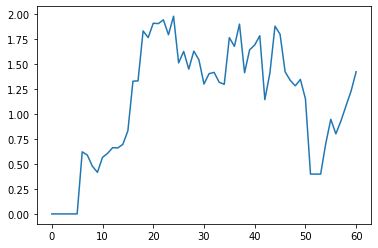

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,404,1.298083
1,4506,3.388239
2,2887,2.884515
3,5728,2.611114
4,28551,1.899238
5,7080,3.481087
6,2161,1.691319
7,1786,2.641255
8,998,3.918507


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5158113412986105,
 'clustered_split_factor': 51,
 'clusterer': <__main__.KpiSimClust object at 0x7f55a53e6640>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0,
 'split': 'state',
 'split_variance': 0.5158113412986105}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust    0
dtype: int64

state_clust    0
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3417, 51)
|--- x0_34.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x0_19.0 <= 0.50
|   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_20.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_37.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 25
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.02]
|   |   |   |   |   |   |   |   |   |--- x0_37.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.19]
|   |   |   |   |   |   |   |   |--- x0_20.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [3.12]
|   |   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.27]
|   |   |   

,sessions,rps
clust,,
35,15674,2.421838
36,6459,2.763560
37,12648,2.669016
38,3581,2.686116
39,3420,3.169837
40,7720,2.638315
41,13146,2.618551
42,2992,2.758300
43,5728,2.611114


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (36, 2),
 'cluster_variance': 0.477233402853814,
 'clustered_split_factor': 36,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b323f5b0>,
 'fit_shape': (51, 2),
 'rps_mae': 0.06506912632410537,
 'split': 'state',
 'split_variance': 0.5158113412986105}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,11,0.544545
0.0,3829,2.413898
1.0,545,3.440780
2.0,2755,3.377592
3.0,1,0.000000
...,...,...
59.0,17172,2.681868
60.0,66899,3.002482
61.0,312,1.534263


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (65, 2),
 'cluster_variance': 0.47355475395092994,
 'clustered_split_factor': 333,
 'clusterer': <__main__.AggRPSClust object at 0x7f558dc906d0>,
 'fit_shape': (365, 2),
 'rps_mae': 0.8504731682244491,
 'split': 'location',
 'split_variance': 0.6365830290683981}


state    0
dma      0
dtype: int64

state      0
dma      635
dtype: int64

|X| (22798, 253)
|--- x1_501 <= 0.50
|   |--- x0_CA <= 0.50
|   |   |--- x0_MA <= 0.50
|   |   |   |--- x0_FL <= 0.50
|   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |--- x0_MD <= 0.50
|   |   |   |   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_TX <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_CO <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |   |   |   |   |   |   |--- x0_CO >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.90]
|   |   |   |   |   |   |   |   |   |--- x0_TX >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_641 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- x1_641 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.51]
|   |   |   |   |   |   |   |   |--- x

,sessions,rps
clust,,
34,17961,2.275984
35,3017,2.559481
36,3420,3.169837
37,3581,2.686116
39,3434,2.644721
40,3025,2.898468
42,6184,2.766277
43,6423,2.576638
44,2992,2.758300


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (59, 2),
 'cluster_variance': 0.48215065695194587,
 'clustered_split_factor': 83,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55b35c99a0>,
 'fit_shape': (365, 2),
 'rps_mae': 0.6010234421811776,
 'split': 'location',
 'split_variance': 0.6365830290683981}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


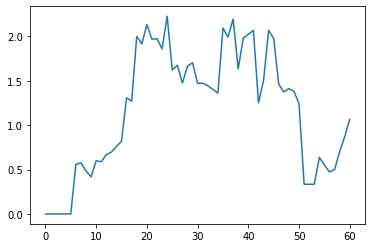

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,11,0.544545
0.0,53,1.279623
1.0,3662,2.156764
2.0,70,2.164228
3.0,48,6.750833
...,...,...
59.0,106,2.948019
60.0,48,5.627500
61.0,1155,3.103744


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (65, 2),
 'cluster_variance': 0.4527451262065325,
 'clustered_split_factor': 335,
 'clusterer': <__main__.KpiSimClust object at 0x7f55b35c9a00>,
 'fit_shape': (365, 2),
 'rps_mae': 0.8828993817728177,
 'split': 'location',
 'split_variance': 0.6365830290683981}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust

state_clust    0
dma_clust      0
dtype: int64

state_clust      0
dma_clust      508
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (20261, 109)
|--- x1_29.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x0_9.0 <= 0.50
|   |   |   |--- x1_28.0 <= 0.50
|   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |--- x1_43.0 <= 0.50
|   |   |   |   |   |   |--- x0_20.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_13.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_37.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_19.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.20]
|   |   |   |   |   |   |   |   |   |--- x1_19.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_43.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.84]
|   |   |   |   |   |   |   |   |   |   |--- x0_43.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.74]
|   |   |   |   |   |   |  

,sessions,rps
clust,,
24,19911,2.446491
27,2854,2.765008
28,3025,2.898468
29,3530,1.910797
30,4160,2.925787
31,3354,2.582422
32,2942,3.195597
33,5183,2.844385
34,3581,2.686116


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (53, 2),
 'cluster_variance': 0.46977862585638147,
 'clustered_split_factor': 180,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b81c8eb0>,
 'fit_shape': (365, 2),
 'rps_mae': 0.6360636665295729,
 'split': 'location',
 'split_variance': 0.6365830290683981}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,9,0.000000
0.0,8743,2.053058
1.0,1285,2.118239
3.0,15337,3.587334
4.0,1332,2.915384
...,...,...
59.0,4055,1.650938
60.0,8239,2.583946
61.0,45,0.713556


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5601884088703253,
 'clustered_split_factor': 246,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a558f1c0>,
 'fit_shape': (1042, 2),
 'rps_mae': 1.4735485132528772,
 'split': 'dma_os',
 'split_variance': 0.9077760310937965}


dma                 0
operating_system    0
dtype: int64

dma                 1773
operating_system      42
dtype: int64

|X| (66487, 208)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x0_501 <= 0.50
|   |   |   |--- x0_506 <= 0.50
|   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |--- x0_524 <= 0.50
|   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_iPadOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_602 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.23]
|   |   |   |   |   |   |   |   |   |   |--- x0_602 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.24]
|   |   |   |   |   |   |   |   |   |--- x1_iPadOS >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.42]
|   |   |   |   |   |   |   |   |--- x0_623 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.55]
|   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.73]
|   |   |   |   |   |

,sessions,rps
clust,,
11,55362,2.510196
12,3174,2.443914
13,6285,2.804037
14,3883,3.028110
15,3369,2.849703
25,70909,2.439252
26,4842,2.493212
27,4595,2.296687
28,5183,2.623020


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (28, 2),
 'cluster_variance': 0.4560016540424025,
 'clustered_split_factor': 40,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55b362d100>,
 'fit_shape': (1042, 2),
 'rps_mae': 1.428524790172753,
 'split': 'dma_os',
 'split_variance': 0.9077760310937965}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


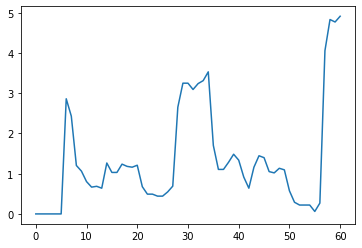

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,9,0.000000
0.0,854,2.766662
1.0,24193,2.412216
2.0,92,2.469622
3.0,3663,2.563496
...,...,...
59.0,762,3.000668
60.0,281,3.540300
61.0,889,2.763913


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (65, 2),
 'cluster_variance': 0.48406698927469366,
 'clustered_split_factor': 270,
 'clusterer': <__main__.KpiSimClust object at 0x7f55b362d610>,
 'fit_shape': (1042, 2),
 'rps_mae': 1.5008707560425636,
 'split': 'dma_os',
 'split_variance': 0.9077760310937965}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust                 0
operating_system_clust    0
dtype: int64

dma_clust                 1322
operating_system_clust      42
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (19538, 64)
|--- x1_3.0 <= 0.50
|   |--- x0_32.0 <= 0.50
|   |   |--- x1_1.0 <= 0.50
|   |   |   |--- x0_33.0 <= 0.50
|   |   |   |   |--- x0_38.0 <= 0.50
|   |   |   |   |   |--- x0_48.0 <= 0.50
|   |   |   |   |   |   |--- x0_8.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_55.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_62.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x1_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.65]
|   |   |   |   |   |   |   |   |   |--- x0_62.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.93]
|   |   |   |   |   |   |   |   |--- x0_55.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.80]
|   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |--- x0_11.0 <= 0.50
|   |   |   |

,sessions,rps
clust,,
17,17613,2.556656
18,3782,2.423870
19,8120,2.587270
20,6150,2.898757
21,6190,2.643930
22,7825,2.686354
23,2800,2.787966
24,5382,2.927759
25,3881,2.407376


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (45, 2),
 'cluster_variance': 0.5266013887119281,
 'clustered_split_factor': 60,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55a54e9a30>,
 'fit_shape': (1042, 2),
 'rps_mae': 1.4549068151760698,
 'split': 'dma_os',
 'split_variance': 0.9077760310937965}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,3471,3.101754
1.0,855,1.710483
2.0,1,0.000000
3.0,639,3.797524
4.0,28895,2.598442
...,...,...
59.0,7527,2.357520
60.0,726,3.689524
61.0,5621,2.542578


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.600456753800476,
 'clustered_split_factor': 138,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a570e7c0>,
 'fit_shape': (625, 2),
 'rps_mae': 1.1525699963894203,
 'split': 'dma_device',
 'split_variance': 0.8334466798914275}


dma       0
device    0
dtype: int64

dma       1213
device       0
dtype: int64

|X| (40347, 205)
|--- x1_DESK <= 0.50
|   |--- x0_501 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_524 <= 0.50
|   |   |   |   |--- x1_TBLT <= 0.50
|   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |   |   |--- x0_807 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_751 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- x0_819 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.75]
|   |   |   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.40]
|   |   |   |   |   |   |   |   |--- x0_751 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.56]
|   |   |   |   |   |   |   |--- x0_807 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.55]
|   |   |   |   |  

,sessions,rps
clust,,
20,94483,2.433611
21,4074,2.441173
22,7575,2.358483
23,7127,2.508244
24,2722,1.984089
25,3111,2.353038
26,3579,2.390782
27,5919,2.137095
28,4007,2.316850


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (31, 2),
 'cluster_variance': 0.5190804157145208,
 'clustered_split_factor': 34,
 'clusterer': <__main__.TreeRPSClust object at 0x7f558e73f550>,
 'fit_shape': (625, 2),
 'rps_mae': 1.045865847422455,
 'split': 'dma_device',
 'split_variance': 0.8334466798914275}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


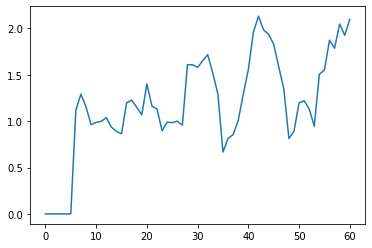

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,8295,2.080160
1.0,174,2.736386
2.0,55,2.098909
3.0,9781,3.016301
4.0,2062,2.492589
...,...,...
59.0,8,5.807500
60.0,63,2.881270
61.0,94,0.900162


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5551465704685479,
 'clustered_split_factor': 145,
 'clusterer': <__main__.KpiSimClust object at 0x7f558e73fcd0>,
 'fit_shape': (625, 2),
 'rps_mae': 1.1736432132712722,
 'split': 'dma_device',
 'split_variance': 0.8334466798914275}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust       0
device_clust    0
dtype: int64

dma_clust       899
device_clust      0
dtype: int64

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (12012, 61)
|--- x1_0.0 <= 0.50
|   |--- x0_42.0 <= 0.50
|   |   |--- x0_33.0 <= 0.50
|   |   |   |--- x0_25.0 <= 0.50
|   |   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |--- value: [2.73]
|   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |--- x0_61.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_29.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_21.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_62.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_16.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- x0_16.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.33]
|   |   |   |   |   |   |   |   |   |--- x0_62.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.38]
|   |   |   |   |   |   |   |   |--- x0_21.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.58]
|   |   |   |   |   |   |  

,sessions,rps
clust,,
6,8928,3.032941
21,20344,2.443525
22,2911,2.233221
23,14020,2.453813
24,11348,2.475209
25,3160,2.236619
26,3101,2.660125
27,6332,2.641950
28,10582,2.265845


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (34, 2),
 'cluster_variance': 0.5859272956348817,
 'clustered_split_factor': 38,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b84c6460>,
 'fit_shape': (625, 2),
 'rps_mae': 1.159365024369909,
 'split': 'dma_device',
 'split_variance': 0.8334466798914275}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,161,3.367702
0.0,957,2.875370
1.0,9844,3.351520
2.0,2,0.000000
3.0,4732,2.602548
...,...,...
59.0,1940,2.774241
60.0,27,6.892593
61.0,5051,3.350195


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.5400320123908073,
 'clustered_split_factor': 381,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a53e25e0>,
 'fit_shape': (1837, 2),
 'rps_mae': 1.564159511763891,
 'split': 'dma_os_device',
 'split_variance': 1.0970045171867018}


dma                 0
operating_system    0
device              0
dtype: int64

dma                 1875
operating_system      42
device                 0
dtype: int64

|X| (95148, 211)
|--- x2_DESK <= 0.50
|   |--- x0_501 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_524 <= 0.50
|   |   |   |   |--- x2_TBLT <= 0.50
|   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |   |   |--- x0_807 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_751 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x0_819 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.75]
|   |   |   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.64]
|   |   |   |   |   |   |   |   |   |   |--- x1_iOS >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.24]
|   |   |   |   |   |   |   |   |--- x0

,sessions,rps
clust,,
16,41749,2.421646
17,2986,2.453028
20,68507,2.421166
21,4589,2.296963
22,4834,2.496056
23,5918,2.137456
24,4007,2.316850
25,2923,2.238307
26,3942,1.769234


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (33, 2),
 'cluster_variance': 0.5221369672503884,
 'clustered_split_factor': 122,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a55e8880>,
 'fit_shape': (1837, 2),
 'rps_mae': 1.5116094399820543,
 'split': 'dma_os_device',
 'split_variance': 1.0970045171867018}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


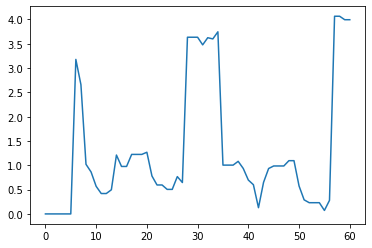

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,161,3.367702
0.0,777,2.267233
1.0,288,1.593066
2.0,21510,1.949445
3.0,624,2.777558
...,...,...
59.0,187,2.539796
60.0,96,2.092188
61.0,904,2.997228


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (65, 2),
 'cluster_variance': 0.4811821943328648,
 'clustered_split_factor': 448,
 'clusterer': <__main__.KpiSimClust object at 0x7f55a554e8b0>,
 'fit_shape': (1837, 2),
 'rps_mae': 1.5818962537704384,
 'split': 'dma_os_device',
 'split_variance': 1.0970045171867018}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust                 0
operating_system_clust    0
device_clust              0
dtype: int64

dma_clust                 1368
operating_system_clust      42
device_clust                 0
dtype: int64

|X| (31840, 67)
|--- x2_0.0 <= 0.50
|   |--- x0_62.0 <= 0.50
|   |   |--- x0_14.0 <= 0.50
|   |   |   |--- x0_26.0 <= 0.50
|   |   |   |   |--- x2_2.0 <= 0.50
|   |   |   |   |   |--- x0_11.0 <= 0.50
|   |   |   |   |   |   |--- x0_0.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_34.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_44.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_27.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_32.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- x0_32.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- x0_27.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.38]
|   |   |   |   |   |   |   |   |   |   |--- x1_0.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.39]
|   |   |   |   | 

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
19,10049,2.462014
20,2454,2.171418
21,2860,2.530991
24,19149,2.251707
25,4225,2.660022
26,4679,2.548427
27,5687,2.510607
29,7250,2.413729
30,13275,2.291045


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (53, 2),
 'cluster_variance': 0.5664014070343825,
 'clustered_split_factor': 167,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b362dc10>,
 'fit_shape': (1837, 2),
 'rps_mae': 1.5317620123998932,
 'split': 'dma_os_device',
 'split_variance': 1.0970045171867018}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,9,0.000000
0.0,3428,1.770833
1.0,499,1.485456
2.0,9453,3.764762
3.0,446,2.028202
...,...,...
59.0,28,6.062500
60.0,30793,2.613616
61.0,2500,1.521626


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6259321792417737,
 'clustered_split_factor': 144,
 'clusterer': <__main__.AggRPSClust object at 0x7f558e73f1f0>,
 'fit_shape': (261, 2),
 'rps_mae': 0.8220607836363808,
 'split': 'state_os',
 'split_variance': 0.7072532353609291}


state               0
operating_system    0
dtype: int64

state                0
operating_system    42
dtype: int64

|X| (17084, 57)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x0_NY <= 0.50
|   |   |   |--- x0_CA <= 0.50
|   |   |   |   |--- x0_MA <= 0.50
|   |   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.78]
|   |   |   |   |   |   |   |   |   |--- x1_iOS >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.61]
|   |   |   |   |   |   |   |

,sessions,rps
clust,,
17,31593,2.595617
18,3232,2.604083
19,3030,2.564046
20,3689,2.479516
21,2314,2.552446
22,9727,2.947564
23,5437,2.999763
24,4586,3.200809
36,32857,2.373828


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5299522656604649,
 'clustered_split_factor': 64,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a434c190>,
 'fit_shape': (261, 2),
 'rps_mae': 0.6815177423327429,
 'split': 'state_os',
 'split_variance': 0.7072532353609291}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


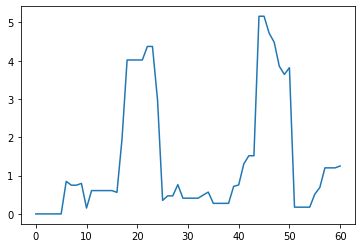

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,9,0.000000
0.0,5783,2.086286
1.0,188,1.598612
2.0,18257,3.640984
3.0,5095,1.459514
...,...,...
59.0,349,2.251826
60.0,8611,2.614970
61.0,23,1.721739


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6014359935809244,
 'clustered_split_factor': 136,
 'clusterer': <__main__.KpiSimClust object at 0x7f55a434c070>,
 'fit_shape': (261, 2),
 'rps_mae': 0.850055232511764,
 'split': 'state_os',
 'split_variance': 0.7072532353609291}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust               0
operating_system_clust    0
dtype: int64

state_clust                0
operating_system_clust    42
dtype: int64

|X| (17084, 57)
|--- x1_3.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x0_34.0 <= 0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.78]
|   |   |   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.61]
|   |   |   |   | 

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
17,31593,2.595617
18,3232,2.604083
19,3030,2.564046
20,3689,2.479516
21,2314,2.552446
22,9727,2.947564
23,5437,2.999763
24,4586,3.200809
36,32857,2.373828


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5299522656604649,
 'clustered_split_factor': 64,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55a434ca90>,
 'fit_shape': (261, 2),
 'rps_mae': 0.6815177423327429,
 'split': 'state_os',
 'split_variance': 0.7072532353609291}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,167,2.914735
1,7458,1.853086
2,2222,3.141235
3,889,1.785328
4,41320,2.698637
...,...,...
59,153,2.869869
60,3645,3.036065
61,11184,3.683540


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6479544282655725,
 'clustered_split_factor': 85,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a558f8e0>,
 'fit_shape': (153, 2),
 'rps_mae': 0.5367885962313466,
 'split': 'state_device',
 'split_variance': 0.7047068628733265}


state     0
device    0
dtype: int64

state     0
device    0
dtype: int64

|X| (10231, 54)
|--- x1_DESK <= 0.50
|   |--- x0_NY <= 0.50
|   |   |--- x0_CA <= 0.50
|   |   |   |--- x0_MA <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x1_PHON <= 0.50
|   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |--- x1_PHON >  0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_OR <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |   |   |   |   |   |--- x0_OR >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |   |--- x0_WA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |--- x0_FL >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.86]
|   |   |   |   |   |   |   |--- x0_MN >  0.50


,sessions,rps
clust,,
6,9614,2.949250
28,30612,2.391198
29,3217,1.896329
30,7729,2.293232
31,8650,2.343264
32,5269,2.502784
33,4250,2.345638
34,5216,2.452658
35,2483,2.758753


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5945940679505097,
 'clustered_split_factor': 48,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55a57c4bb0>,
 'fit_shape': (153, 2),
 'rps_mae': 0.3716266936612321,
 'split': 'state_device',
 'split_variance': 0.7047068628733265}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


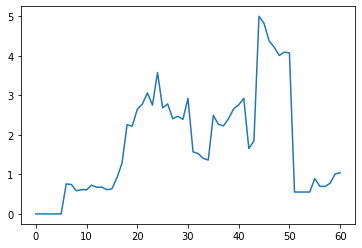

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,1324,2.926658
1,106,2.499915
2,28,4.848214
3,6260,2.831159
4,3673,4.028178
...,...,...
59,181,2.536489
60,41,5.847561
61,1175,1.902355


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6271823459986464,
 'clustered_split_factor': 80,
 'clusterer': <__main__.KpiSimClust object at 0x7f55a57c4ca0>,
 'fit_shape': (153, 2),
 'rps_mae': 0.5851744691335076,
 'split': 'state_device',
 'split_variance': 0.7047068628733265}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust     0
device_clust    0
dtype: int64

state_clust     0
device_clust    0
dtype: int64

|X| (10231, 54)
|--- x1_0.0 <= 0.50
|   |--- x0_34.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_37.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |   |   |   |   |   |--- x0_37.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |   |--- x0_47.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |--- x0_9.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.86]
|   |   |   |   |   |   |   |

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
6,9614,2.949250
28,30612,2.391198
29,3217,1.896329
30,7729,2.293232
31,8650,2.343264
32,5269,2.502784
33,4250,2.345638
34,5216,2.452658
35,2483,2.758753


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5945940679505097,
 'clustered_split_factor': 48,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55a53b0b50>,
 'fit_shape': (153, 2),
 'rps_mae': 0.3716266936612321,
 'split': 'state_device',
 'split_variance': 0.7047068628733265}


<ipython-input-275-bfd50e918ada>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,57,2.480598
0.0,3,0.000000
1.0,238,2.723697
2.0,537,3.800708
4.0,11978,1.728392
5.0,11505,3.646875
6.0,4,0.000000
8.0,33,2.585152
9.0,4,4.340745


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (60, 2),
 'cluster_variance': 0.6102939440669799,
 'clustered_split_factor': 244,
 'clusterer': <__main__.AggRPSClust object at 0x7f55a53cfa00>,
 'fit_shape': (583, 2),
 'rps_mae': 0.9617664416769502,
 'split': 'state_os_device',
 'split_variance': 0.8120828248609615}


state               0
operating_system    0
device              0
dtype: int64

state                0
operating_system    42
device               0
dtype: int64

|X| (30344, 60)
|--- x2_DESK <= 0.50
|   |--- x0_NY <= 0.50
|   |   |--- x0_CA <= 0.50
|   |   |   |--- x0_MA <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x2_TBLT <= 0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_OR <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- x0_OR >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |   |--- x0_WA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |--- x0_FL >  0.50
|   |   |   |   |   |   |   |   |   |--- x1_Linux <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.86]
|   |   |   |   |   |   |   |   |   |--- x1_Linux >  0.50
|   |   |  

,sessions,rps
clust,,
18,26834,2.447520
19,2941,2.507768
20,3455,2.429559
27,31114,2.407113
28,5195,2.285873
29,3138,2.481513
30,3286,2.625601
31,3258,2.517127
32,5037,2.219790


{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (47, 2),
 'cluster_variance': 0.5792248134783329,
 'clustered_split_factor': 161,
 'clusterer': <__main__.TreeRPSClust object at 0x7f55f52fd490>,
 'fit_shape': (583, 2),
 'rps_mae': 0.7773747800945268,
 'split': 'state_os_device',
 'split_variance': 0.8120828248609615}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


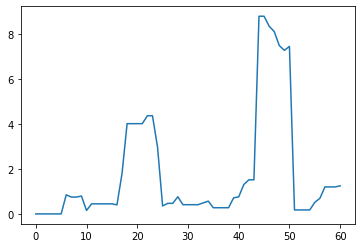

<ipython-input-275-bfd50e918ada>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,57,2.480598
0.0,194,2.424794
1.0,8324,1.710778
2.0,106,1.478687
3.0,10948,3.362950
...,...,...
59.0,546,2.141966
60.0,286,2.484219
61.0,3490,2.347280


{'clust_mtd': 'KpiSimClust',
 'clust_shape': (65, 2),
 'cluster_variance': 0.5835356579341326,
 'clustered_split_factor': 256,
 'clusterer': <__main__.KpiSimClust object at 0x7f55b37b4d90>,
 'fit_shape': (583, 2),
 'rps_mae': 0.9753581128834369,
 'split': 'state_os_device',
 'split_variance': 0.8120828248609615}


<ipython-input-276-b27ba78c15c7>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-275-bfd50e918ada>:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust               0
operating_system_clust    0
device_clust              0
dtype: int64

state_clust                0
operating_system_clust    42
device_clust               0
dtype: int64

|X| (30344, 60)
|--- x2_0.0 <= 0.50
|   |--- x0_34.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x2_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_37.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- x0_37.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |   |--- x0_47.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |--- x0_9.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.86]
|   |   |   |   |   |   |   |   |   |--- x1_0.0 >  0

<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-275-bfd50e918ada>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
18,26834,2.447520
19,2941,2.507768
20,3455,2.429559
27,31114,2.407113
28,5195,2.285873
29,3138,2.481513
30,3286,2.625601
31,3258,2.517127
32,5037,2.219790


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (47, 2),
 'cluster_variance': 0.5792248134783329,
 'clustered_split_factor': 161,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7f55b3272790>,
 'fit_shape': (583, 2),
 'rps_mae': 0.7773747800945268,
 'split': 'state_os_device',
 'split_variance': 0.8120828248609615}


,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor,rps_mae
0,AggRPSClust,<__main__.AggRPSClust object at 0x7f55b327ceb0>,browser,"(3, 2)","(3, 2)",0.008343,0.008343,6,0.000000
1,TreeRPSClust,<__main__.TreeRPSClust object at 0x7f55858def40>,browser,"(3, 2)","(1, 2)",0.008343,0.000000,1,0.000120
2,KpiSimClust,<__main__.KpiSimClust object at 0x7f55858de370>,browser,"(3, 2)","(3, 2)",0.008343,0.008343,6,0.000000
3,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7f55...,browser,"(3, 2)","(1, 2)",0.008343,0.000000,1,0.000120
4,AggRPSClust,<__main__.AggRPSClust object at 0x7f55a43568e0>,operating_system,"(7, 2)","(7, 2)",0.365795,0.365795,10,0.000000
5,TreeRPSClust,<__main__.TreeRPSClust object at 0x7f55a53e63a0>,operating_system,"(7, 2)","(5, 2)",0.365795,0.365536,5,0.000091
6,KpiSimClust,<__main__.KpiSimClust object at 0x7f55e7d2efd0>,operating_system,"(7, 2)","(7, 2)",0.365795,0.365795,10,0.000000
7,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7f55...,operating_system,"(7, 2)","(5, 2)",0.365795,0.365536,5,0.000091
8,AggRPSClust,<__main__.AggRPSClust object at 0x7f5585e257c0>,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000
9,TreeRPSClust,<__main__.TreeRPSClust object at 0x7f55a558f6a0>,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000


In [276]:
perfD = []
for split,rps_df in [*split2aggrps.items()]:
    
    rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
    rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
    rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
    rps_df["rps"] = rps_df["rps_avg"]
    fitI = rps_df.reset_index()['utc_dt'].dt.date < eval_date
    fitI.index = rps_df.index

    for clust_mtd in [AggRPSClust,TreeRPSClust,KpiSimClust,HybridCorrTreeClust]:
        clusterer = clust_mtd().fit(rps_df[fitI],None)
        rps_df["clust"] = -1
        rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
        rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])
        rps_df["clust"] = rps_df["clust"].fillna(-1)
        rps_df["rps_clust"] = rps_df \
            .groupby(["clust","utc_dt"]) \
            ["rps"].transform(get_wavg_by(rps_df,"sessions"))
        daily_rps_mae = (rps_df["rps"] - rps_df["rps_clust"]).abs()
            
        agg_rps_df = rps_df \
            [~fitI] \
            .groupby(rps_df.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        clust_rps_df = rps_df \
            [~fitI] \
            .groupby("clust") \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        ipydisp(clust_rps_df)
        assert clust_rps_df["rps"].max() <= agg_rps_df["rps"].max()
        rps_wavg = wavg(agg_rps_df[["rps"]], agg_rps_df["sessions"])
        rps_clust_wavg = wavg(clust_rps_df[["rps"]], clust_rps_df["sessions"])
        assert all((rps_wavg - rps_clust_wavg).abs() < 1e-2), (rps_wavg, rps_clust_wavg)        
        
        perfd = {
            "clust_mtd": clusterer.__class__.__name__,
            "clusterer": clusterer,
            "split": split,
            "fit_shape": agg_rps_df.shape,
            "clust_shape": clust_rps_df.shape,
            "split_variance": wstd(agg_rps_df["rps"], agg_rps_df["sessions"]),
            "cluster_variance": wstd(clust_rps_df["rps"], clust_rps_df["sessions"]),
            # wstd(rps_df["rps_avg"],rps_df["sessions"])
            "clustered_split_factor": get_split_factor(rps_df),
            "rps_mae": wavg(daily_rps_mae,rps_df["sessions"]),
        }
        perfD.append(perfd)
        pprint.pprint(perfd)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)

In [277]:
perfdf.tail(50)

,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor,rps_mae
6,KpiSimClust,<__main__.KpiSimClust object at 0x7f55e7d2efd0>,operating_system,"(7, 2)","(7, 2)",0.365795,0.365795,10,0.000000
7,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7f55...,operating_system,"(7, 2)","(5, 2)",0.365795,0.365536,5,0.000091
8,AggRPSClust,<__main__.AggRPSClust object at 0x7f5585e257c0>,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000
9,TreeRPSClust,<__main__.TreeRPSClust object at 0x7f55a558f6a0>,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000
10,KpiSimClust,<__main__.KpiSimClust object at 0x7f55b3259b50>,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000
11,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7f55...,device,"(3, 2)","(3, 2)",0.390781,0.390781,3,0.000000
12,AggRPSClust,<__main__.AggRPSClust object at 0x7f5585fa0520>,product,"(2, 2)","(2, 2)",0.107734,0.107734,2,0.000000
13,TreeRPSClust,<__main__.TreeRPSClust object at 0x7f55b3255be0>,product,"(2, 2)","(2, 2)",0.107734,0.107734,2,0.000000
14,KpiSimClust,<__main__.KpiSimClust object at 0x7f55b32758e0>,product,"(2, 2)","(2, 2)",0.107734,0.107734,2,0.000000
15,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7f55...,product,"(2, 2)","(2, 2)",0.107734,0.107734,2,0.000000


In [279]:
split,clusterer = perfdf.loc[49,["split","clusterer"]]
print("split:",split)
rps_df = split2aggrps[split]
rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df["rps"] = rps_df["rps_avg"]
fitI = rps_df.reset_index()['utc_dt'].dt.date < eval_date
fitI.index = rps_df.index

rps_df["clust"] = -1
rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) 
                          for index_col in rps_df.index.names[:-1]}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df.reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: lambda seq: tuple(set(seq))
    }) \
    .sort_index()

assert campaign_df["sessions"].sum() == rps_df["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df["rps_avg"], rps_df["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

split: state_device
|X| (9020, 54)
|X| (4114, 54)


In [285]:
camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "INCLUDE": r[last_field]
    }
    camps.append(camp)

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] \
    .apply(flatten)
for idx, r in excl_campaign_df.iterrows():
    camp = {}
    idx = tuple(idx) if isinstance(idx,(tuple,list,set)) else [idx]
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "EXCLUDE": r[last_field]
    }
    camps.append(camp)

camp_attr_df = pd.DataFrame(camps)
camp_attr_df.to_csv(f"{traffic_source}_campaign_dump.csv")
camp_attr_df

,sessions_60d,rps_avg_60d,device,state
0,95253.0,3.040755,{'INCLUDE': 'DESK'},"{'INCLUDE': ('AL', 'MA', 'SC', 'MN', 'DE', 'KS..."
1,11539.0,3.162102,{'INCLUDE': 'DESK'},"{'INCLUDE': ('PA',)}"
2,6865.0,3.170515,{'INCLUDE': 'DESK'},"{'INCLUDE': ('MI',)}"
3,10041.0,3.159734,{'INCLUDE': 'DESK'},"{'INCLUDE': ('OH',)}"
4,12270.0,3.209734,{'INCLUDE': 'DESK'},"{'INCLUDE': ('IL',)}"
5,9581.0,3.581461,{'INCLUDE': 'DESK'},"{'INCLUDE': ('NC',)}"
6,7292.0,3.369904,{'INCLUDE': 'DESK'},"{'INCLUDE': ('TN',)}"
7,7454.0,3.937256,{'INCLUDE': 'DESK'},"{'INCLUDE': ('CO',)}"
8,12060.0,3.575919,{'INCLUDE': 'DESK'},"{'INCLUDE': ('GA',)}"
9,10004.0,3.839493,{'INCLUDE': 'DESK'},"{'INCLUDE': ('VA',)}"


In [284]:
traffic_source = GOOGLE

In [147]:
import json

TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

from pytaboola.services import AccountService
from pytaboola.services import CampaignService

import itertools
import tqdm
import pandas as pd
import os
from pkg_resources import resource_filename as rscfn


acct_service = AccountService(client)
accnts = acct_service.list()["results"]
NETWORK_ACCNT_ID = "healthcareinc-network"
TEST_ACCNT_ID = "healthcareinc-sc2"
O65_ACCNT_ID = "taboolaaccount-rangaritahealthcarecom"
id2accnt = {a["account_id"]: a for a in accnts}

def accnt_camps(accnt):
    camp_service = CampaignService(client, accnt["account_id"])
    return camp_service.list()
aid2cid2camp = {}
for aid,a in tqdm.tqdm(id2accnt.items()):
    cid2camp = {c["id"]: c for c in accnt_camps(a)}
    aid2cid2camp[aid] = cid2camp

import json
json.dump(aid2cid2camp, open("camps.json", "w"))
O65_accnt_camps = accnt_camps(id2accnt[O65_ACCNT_ID])
print("|065_accnt_camps|:",len(O65_accnt_camps))

test_accnt_camps = accnt_camps(id2accnt[TEST_ACCNT_ID])
print("|test_accnt_camps|",len(test_accnt_camps))

import itertools
cross = itertools.product
import jmespath
get = jmespath.search

active_camps = get(
  "*.*[] | [?is_active]",
  aid2cid2camp,
)
print("|active campaigns|:",len(active_camps))

100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


|065_accnt_camps|: 100


In [261]:
def taboola_targetting_fields(r):
    def pivot(o):
        (t,v),*_ = o.items()
        return {
            "type": t,
            "value": [*v] if isinstance(v,(list,tuple,set)) else [v]
        }
    targetting_fields = {}
    if "device" in r:
        targetting_fields["platform_targeting"] = pivot(r["device"])
    if "state" in r:
        targetting_fields["sub_country_targeting"] = pivot(r["state"])
    if "dma" in r:
        targetting_fields["dma_country_targeting"] = pivot(r["dma"])
    if "operating_system" in r:
        (t,v),*_ = r["operating_system"].items()
        targetting_fields["os_targeting"] = {
            "type": "INCLUDE",
            "value": [
                {
                    "os_family": v
                },
            ],
        }
    return targetting_fields
ipydisp(camp_attr_df.apply(taboola_targetting_fields,axis=1).head())
taboola_targetting_fields(camp_attr_df.iloc[0,:])

0    {'platform_targeting': {'type': 'INCLUDE', 'va...
1    {'platform_targeting': {'type': 'INCLUDE', 'va...
2    {'platform_targeting': {'type': 'INCLUDE', 'va...
3    {'platform_targeting': {'type': 'INCLUDE', 'va...
4    {'platform_targeting': {'type': 'INCLUDE', 'va...
dtype: object

{'platform_targeting': {'type': 'INCLUDE', 'value': ['DESK']},
 'sub_country_targeting': {'type': 'INCLUDE', 'value': ['NY', 'FL', 'CA']},
 'os_targeting': {'type': 'INCLUDE', 'value': [{'os_family': 'Android'}]}}

In [269]:
src_accnt = id2accnt[O65_ACCNT_ID]
src_camp = active_camps[0]
dest_accnt = id2accnt[TEST_ACCNT_ID]

client = TaboolaClient(**TABOOLA_HC_CREDS)
client.authorization_header,client.token_details

resp = requests.post(
    f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
    json={
        "name": src_camp["id"],
        "start_date": (TODAY + 2*DAY).__str__(),
        **taboola_targetting_fields(camp_attr_df.iloc[0]),
    },
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

HTTPError: 400 Client Error: Bad Request for url: https://backstage.taboola.com/backstage/api/1.0/taboolaaccount-rangaritahealthcarecom/campaigns/10798231/duplicate?destination_account=healthcareinc-sc2

In [ ]:
# import requests
# TODAY = NOW.date()
# TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
# for src_camp in active_camps:
#     src_accnt = id2accnt[O65_ACCNT_ID]
#     dest_accnt = id2accnt[TEST_ACCNT_ID]

#     client = TaboolaClient(**TABOOLA_HC_CREDS)
#     client.authorization_header,client.token_details

#     for _,camp_attrs in camp_attr_df.iterrows():
#         resp = requests.post(
#             f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
#             json={
#                 "name": src_camp["id"],
#                 "start_date": (TODAY + 2*DAY).__str__(),
#                 **taboola_targetting_fields(camp_attrs),
#             },
#             params= {
#                 "destination_account": dest_accnt["account_id"],
#             },
#             headers=client.authorization_header,)
#         resp.raise_for_status()

#         new_camp = resp.json()

In [165]:
import json
TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

import requests
import jmespath
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/operating_systems",
    headers=client.authorization_header)
taboola_os = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/platforms",
    headers=client.authorization_header)
taboola_platforms = jmespath.search('results[].name', resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/dma",
    headers=client.authorization_header)
taboola_dmas = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/regions",
    headers=client.authorization_header)
taboola_states = jmespath.search('results[].name',resp.json(),)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))

In [ ]:
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()